<a href="https://colab.research.google.com/github/HarmanDotpy/ML_Scratch/blob/master/KalmanFilter_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
# our implementaion will be using torch
import torch

# some helper libraries
from torch.distributions.multivariate_normal import MultivariateNormal
import matplotlib.pyplot as plt
import seaborn as sb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Kalman Filter Function which takes in process matrices, observation y, previous estimate of x, and previous error covariance and returns current estimate of x, error covariance matrix and innovation vector covariance 




In [0]:
def kalman(A, C, Q, R, y, process_size_q, xhat_prev, P_prev):
  '''
  prior means the prior estimate of the variable at current time For eg xhat_prior = xhat_k'
  prev means the value of the variable at the prev time instant For eg xhat_prev = xhat_k-1
  '''
  xhat_prior = torch.mm(A, xhat_prev)
  P_prior = torch.chain_matmul(A, P_prev, A.t()) + Q
  Sigma_z = torch.chain_matmul(C, P_prior, C.t()) + R
  K = torch.chain_matmul(P_prior, C.t(), torch.inverse(Sigma_z))

  # update values of estimate and the error covariance matrix at this instant
  xhat = xhat_prior + torch.mm(K, (y - torch.mm(C, xhat_prior)))
  P = torch.mm((torch.eye(process_size_q) - torch.mm(K, C)), P_prior)
  return xhat, P, Sigma_z

# Example

### Generating Matrices for generating a process which we will later estimate using the kalman filter function implemented above



In [3]:
# dimension of the process =q and dimension of observation = N
q = 1 
N = 1

#helper matrices to generate process matrices
mat = torch.FloatTensor(q,q).uniform_(0,1)
Zq = 2 * torch.FloatTensor(q, q).uniform_(-1,1)
Zr =  0.1 * torch.FloatTensor(N, N).uniform_(-1,1)

#Initialize Constant process matrices
A = 0.5 * (mat/mat.sum(1).view(q,1)) #(singly - stochastic - matrix) * factor ---- can be any random matrix
C = torch.FloatTensor(N,q).uniform_(0,1) 
Q = torch.mm(Zq, Zq.T)  
R = torch.mm(Zr, Zr.T)
xo = torch.FloatTensor(q, 1).uniform_(0,1)

# A = torch.tensor([[0.5000]]) 

# C = torch.tensor([[0.6634]]) 

# Q = torch.tensor([[0.0055]]) 

# R = torch.tensor([[3.7494e-05]]) 

# xo = torch.tensor([[0.9784]])

print('A = \n{} \n\nC = \n{} \n\nQ = \n{} \n\nR = \n{} \n\nxo = \n{}'.format(A, C, Q, R, xo))

A = 
tensor([[0.5000]]) 

C = 
tensor([[0.5397]]) 

Q = 
tensor([[1.9329]]) 

R = 
tensor([[0.0081]]) 

xo = 
tensor([[0.4591]])


### Generating the process

Our process is x which is hidden from us 

We only have y's which we can access, and use these y's to obtain the estimate of the underlying process x.

In [0]:
# Generating the stochastiic process
x = [xo]
y = []
for i in range(100):
  # with noise
  x.append(torch.mm(A, x[-1]) + MultivariateNormal(torch.zeros(q), Q).sample().view(q,1))
  y.append(torch.mm(C, x[-1]) + MultivariateNormal(torch.zeros(N), R).sample().view(N,1))
x = torch.stack(x)
y = torch.stack(y)


### Visualizing the Process



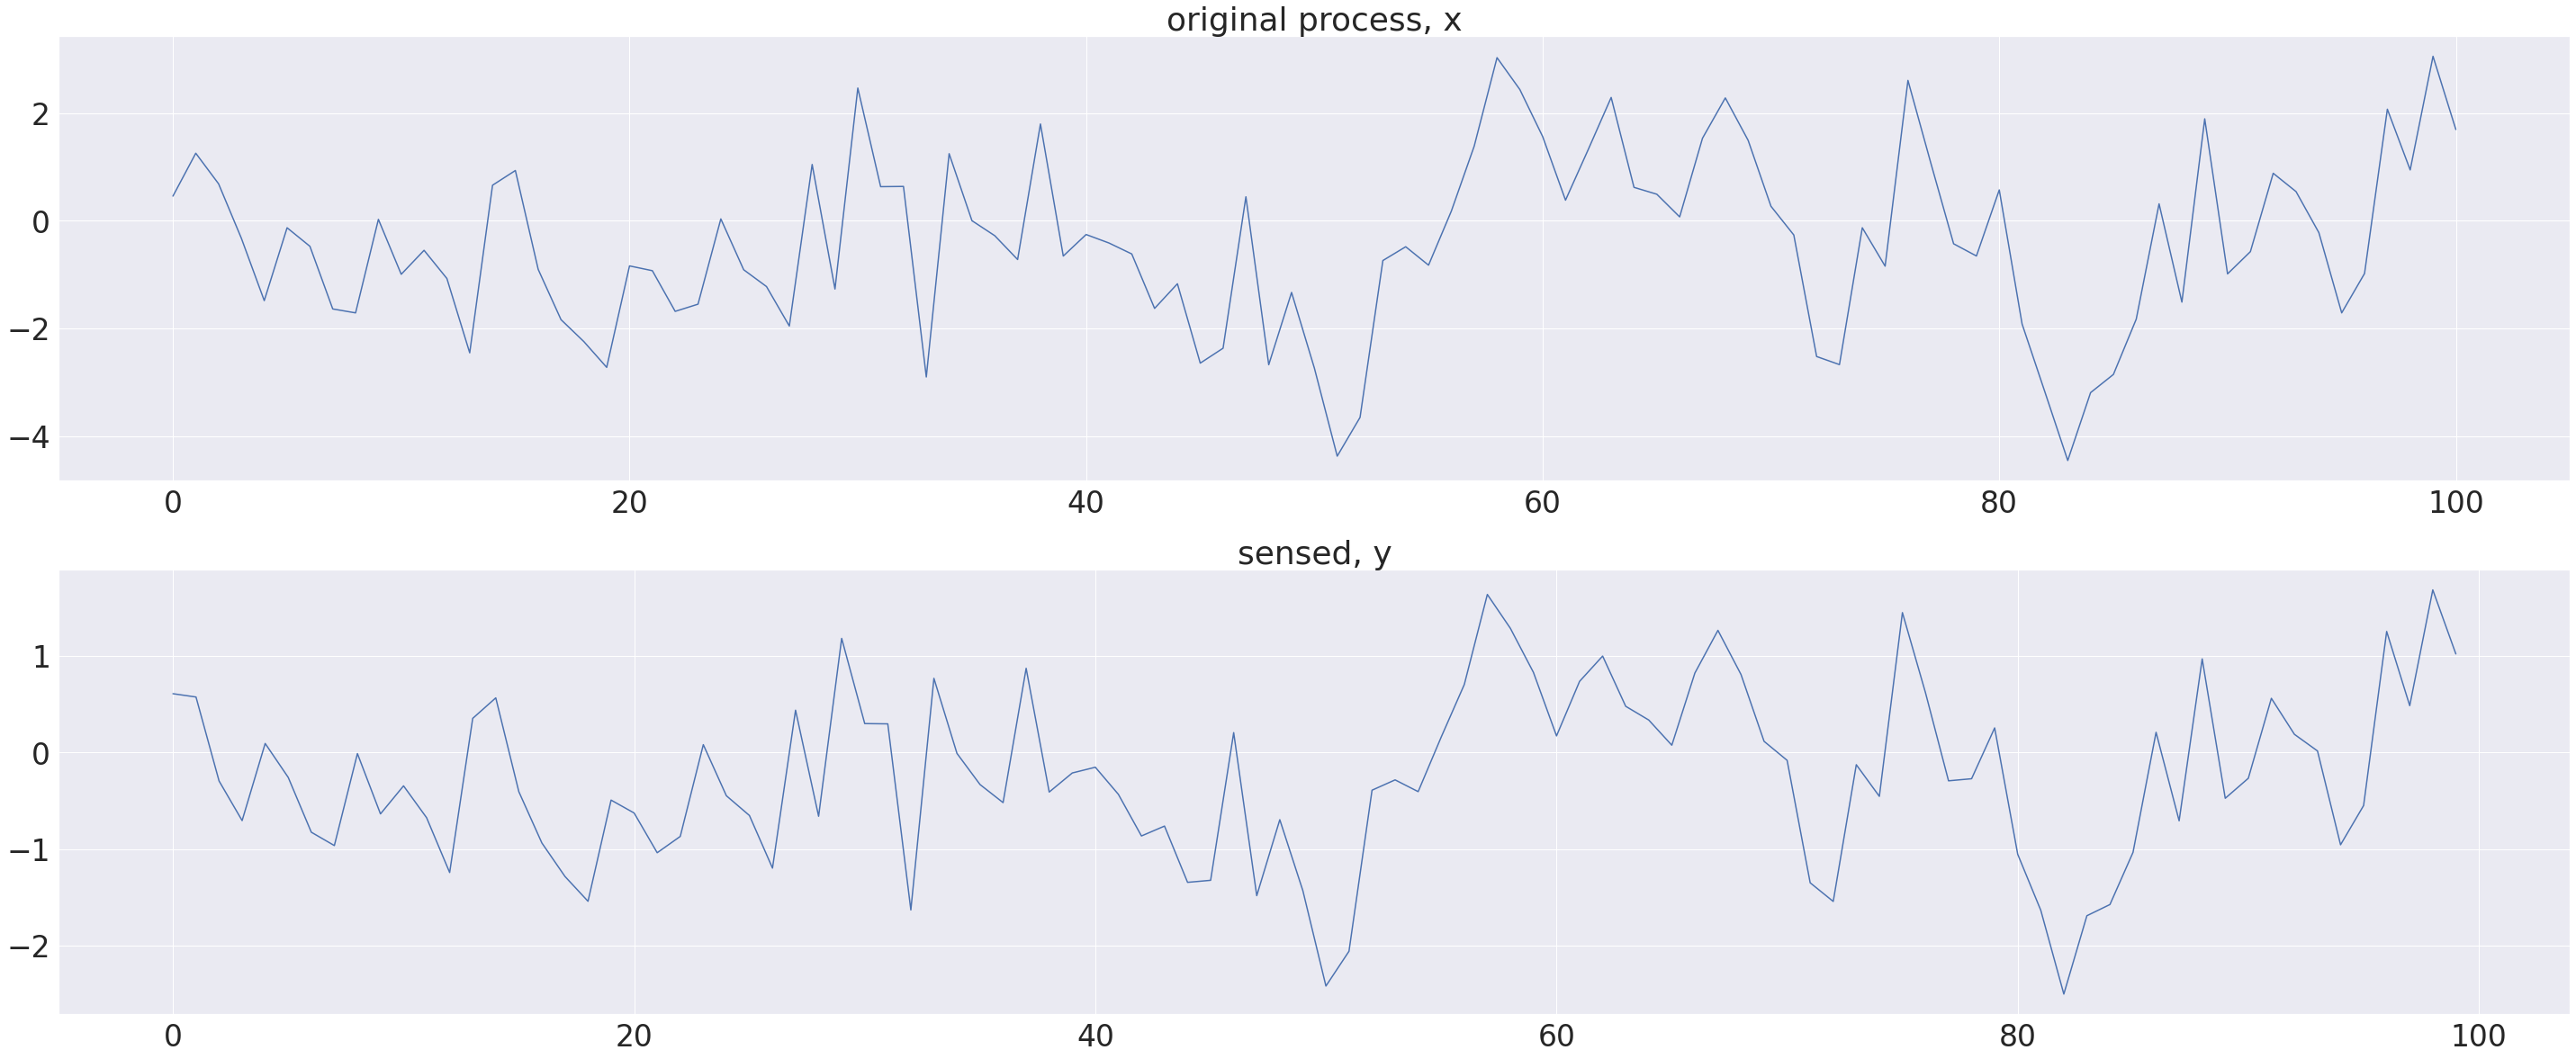

In [5]:
sb.set(font_scale = 3)

fig, axis = plt.subplots(2,1)
axis[0].plot(x[:,0])
axis[0].title.set_text('original process, x')
axis[1].plot(y[:,0])
axis[1].title.set_text('sensed, y')

fig.set_size_inches(w = 50, h = 20)
plt.show()

### Getting the estimates of x by accessing only y's
### The first estimate of x is taken as xhat = zero (or a tensor of zeros, of size q * 1 in case x is a vector)

In [0]:
# xhat = 0 and creating a PSD matrix P for initial step of the kalman filter
xhat = torch.zeros((q,1))
x_estimate = [xhat]
Zp = torch.FloatTensor(q,q).uniform_(-1,1)
P = torch.mm(Zp, Zp.t())

for i in range(100):
  xhat, P, Sigma_z = kalman(A, C, Q, R, y[i], q, xhat, P)
  x_estimate.append(xhat)

x_estimate = torch.stack(x_estimate)

### Visualizing the estimates and the original process

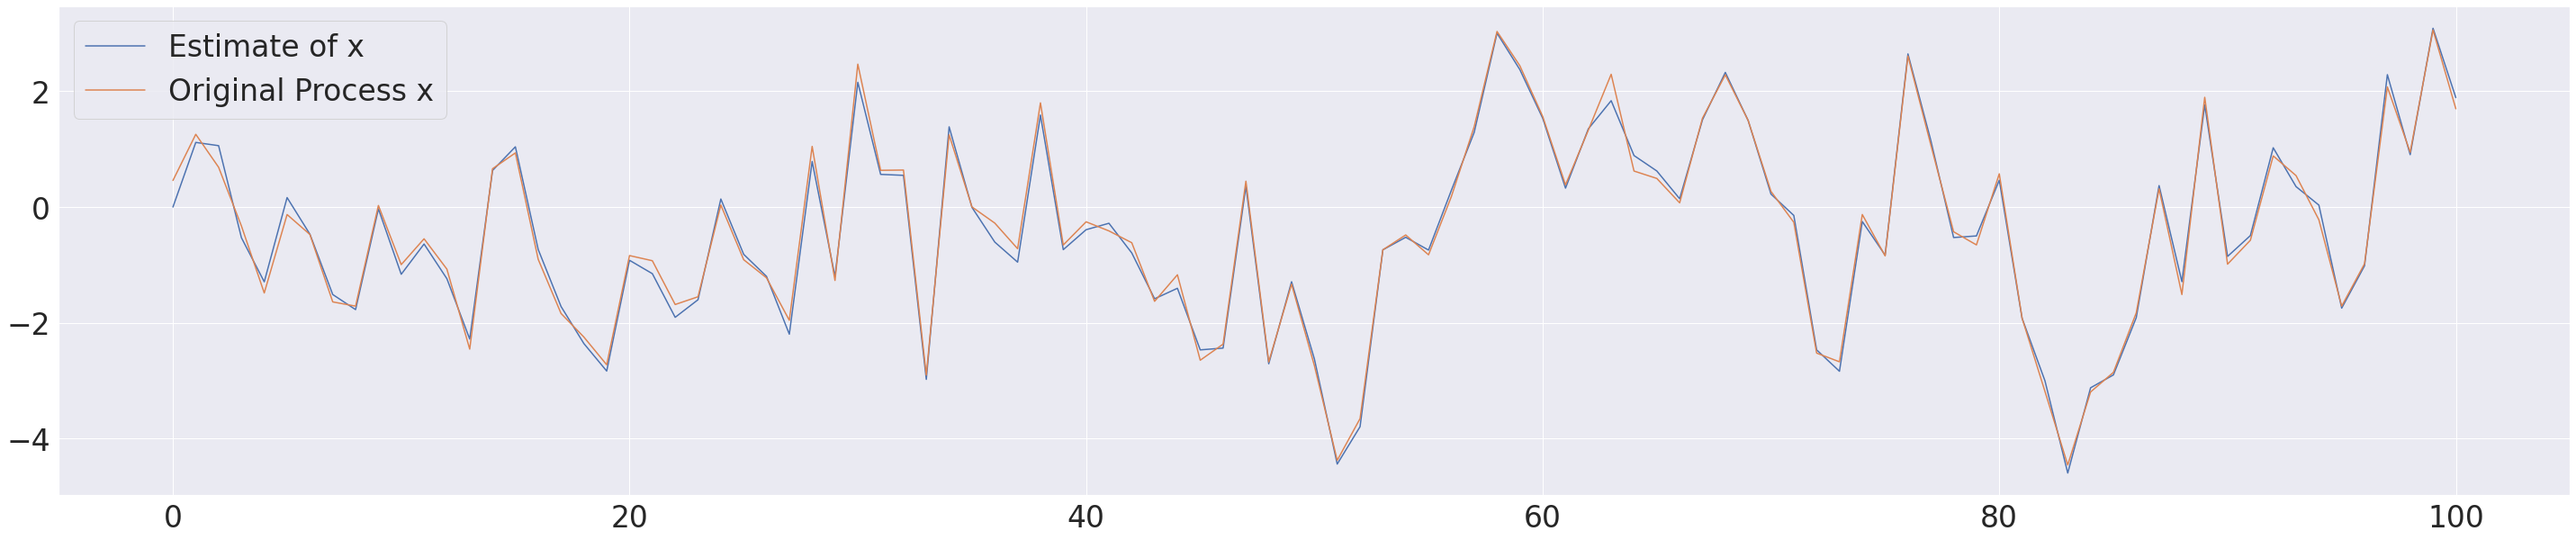

In [13]:
fig, axis = plt.subplots(1,1)
axis.plot(x_estimate[:, 0], label = 'Estimate of x')
axis.plot(x[:, 0], label = 'Original Process x')
axis.legend()

fig.set_size_inches(w = 50, h = 10)
